# Drift Detection using Deepchecks

Import dependencies

In [1]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

Load the iris dataset

In [2]:
iris = load_iris()
training_df = pd.DataFrame(iris.data, columns=iris.feature_names)
training_df.shape[0]

150

In [3]:
training_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Let's say that we have collected some input data from the production deployment of our model...

In [4]:
!python ../scripts/fake-production-data.py -n 150 -o fake-production-data.csv

Now we want to detect potential drifts, i.e., we want to check if the data is still coming from the same distribution as the data we used to train our model.

First, we read in our production data.

In [5]:
fake_production_df = pd.read_csv("fake-production-data.csv", header=None)
fake_production_df.columns = training_df.columns
fake_production_df.shape[0]

150

In [6]:
fake_production_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.1,4.0,4.4,2.3
1,5.3,4.1,5.6,1.9
2,5.3,2.8,1.5,1.0
3,4.6,4.2,4.2,0.8
4,7.1,3.5,1.7,2.4


Let's visualize the different distributions:

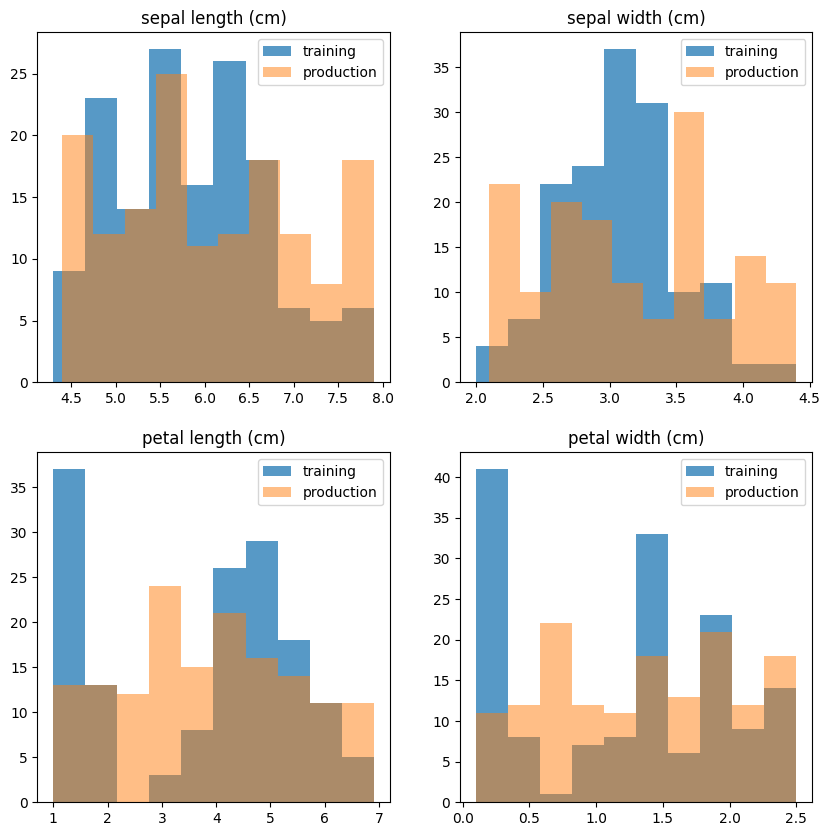

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(training_df["sepal length (cm)"], alpha=0.75, label="training")
axs[0, 0].hist(fake_production_df["sepal length (cm)"], alpha=0.50, label="production")
axs[0, 0].set_title("sepal length (cm)")
axs[0, 0].legend()
axs[0, 1].hist(training_df["sepal width (cm)"], alpha=0.75, label="training")
axs[0, 1].hist(fake_production_df["sepal width (cm)"], alpha=0.50, label="production")
axs[0, 1].set_title("sepal width (cm)")
axs[0, 1].legend()
axs[1, 0].hist(training_df["petal length (cm)"], alpha=0.75, label="training")
axs[1, 0].hist(fake_production_df["petal length (cm)"], alpha=0.50, label="production")
axs[1, 0].set_title("petal length (cm)")
axs[1, 0].legend()
axs[1, 1].hist(training_df["petal width (cm)"], alpha=0.75, label="training")
axs[1, 1].hist(fake_production_df["petal width (cm)"], alpha=0.50, label="production")
axs[1, 1].set_title("petal width (cm)")
axs[1, 1].legend()

# Measuring drift for **univariate features**

Let's use Deepchecks' Dataset class to wrap our training and fake production data.

In [20]:
from deepchecks.tabular import Dataset

# Training dataset
training_df["target"] = iris.target
training_dataset = Dataset(training_df, label="target", cat_features=[])

# Production dataset
production_dataset = Dataset(fake_production_df, cat_features=[])

Now we can build a univariate drift detector that will check each feature in our dataset.

In [22]:
from deepchecks.tabular.checks import FeatureDrift

check = FeatureDrift()
result = check.run(training_dataset, production_dataset)
result

We might also add conditions (remember the Deepchecks concept hierarchy, i.e., suites, checks, and conditions).

For instance:

```python
check_cond = check.add_condition_drift_score_less_than(max_allowed_categorical_score=0.2,
                                                       max_allowed_numeric_score=0.1)
```

# Measuring drift for **multivariate features**

Now let's use Deepchecks to build a multiviariate drift detector.

In [24]:
from deepchecks.tabular.checks import MultivariateDrift

check = MultivariateDrift()
result = check.run(training_dataset, production_dataset)
result

# Measuring **prediction drift**

Finally, let's experiment with Deepchecks' PredictionDrift detector.

Here we need to load one of our trained models and use it to make predictions on the fake production data.

In [28]:
import pickle
from deepchecks.tabular.checks import PredictionDrift

with open('../models/SVC_model.pkl', 'rb') as file:
    model_wrapper = pickle.load(file)

check = PredictionDrift()
result = check.run(training_dataset, production_dataset, model=model_wrapper["model"])
result

/Users/luigiquaranta/.pyenv/versions/3.10.2/envs/fastapi_demo/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator SVC from version 1.0.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations

/Users/luigiquaranta/.pyenv/versions/3.10.2/envs/fastapi_demo/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/luigiquaranta/.pyenv/versions/3.10.2/envs/fastapi_demo/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/luigiquaranta/.pyenv/versions/3.10.2/envs/fastapi_demo/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but SVC was fitted without feature names



## Resources

- [Made With ML > Monitoring Machine Learning Systems > Measuring Drift](https://madewithml.com/courses/mlops/monitoring/#measuring-drift)
- [Alibi Detect Docs > Examples > Categorical and mixed type data drift detection on income prediction](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_chi2ks_adult.html)